#####COSC 6315 - Final Mini Project
####SID - 2156112 

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier



In [2]:
#Upload data
from google.colab import files
uploaded = files.upload()

Saving Loan_Prediction_Data.csv to Loan_Prediction_Data.csv


In [81]:
df = pd.read_csv("/content/Loan_Prediction_Data.csv")

In [82]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [83]:
# STEP 1: Data Exploration

df.nunique()

Loan_ID              614
Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      505
CoapplicantIncome    287
LoanAmount           203
Loan_Amount_Term      10
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

In [84]:
exl_list = ["Loan_Status", "Loan_ID"] # excluded List of columns that are not features
num_cols_list = ["ApplicantIncome",	"CoapplicantIncome",	"LoanAmount"] # columns having numerical values

In [85]:
df[num_cols_list].describe() # to get the statistics of the numerical columns

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,614.000000,614.000000,592.000000
mean,5403.459283,1621.245798,146.412162
std,6109.041673,2926.248369,85.587325
min,150.000000,0.000000,9.000000
25%,2877.500000,0.000000,100.000000
50%,3812.500000,1188.500000,128.000000
75%,5795.000000,2297.250000,168.000000
max,81000.000000,41667.000000,700.000000


In [86]:
# to get the statistics of the categorical columns
df[["Gender", "Dependents", "Married", "Education", "Self_Employed", "Property_Area", "Loan_Status"]].describe()

,Gender,Dependents,Married,Education,Self_Employed,Property_Area,Loan_Status
count,601,599,611,614,582,614,614
unique,2,4,2,2,2,3,2
top,Male,0,Yes,Graduate,No,Semiurban,Y
freq,489,345,398,480,500,233,422


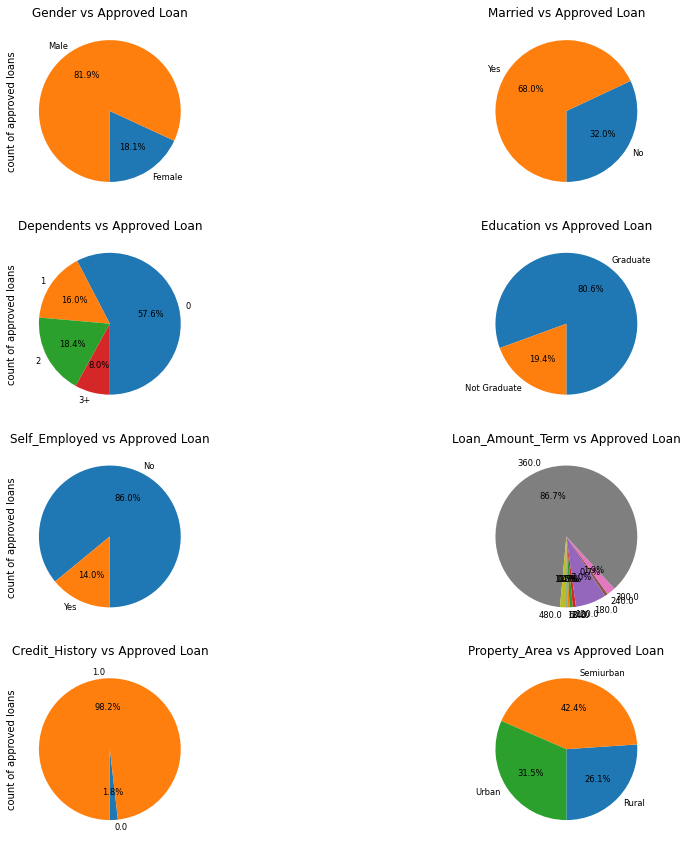

In [87]:

# Plot all the features against the count of approved loans to understand the feature importance and feature selection

# Plot pie charts with the count of approved loans for each category of a feature
pie_chrt = [col for col in df.columns if col not in (exl_list + num_cols_list)]

fig, axs = plt.subplots(4, 2, figsize=(15, 15))
ax_x_max, ax_y_max = 2, 2

for idx, col in enumerate(pie_chrt):
  # Group by features to get the approved loans count for each category
  col_gby = df[df["Loan_Status"] == "Y"][[col, "Loan_Status"]].groupby(col, as_index=False)[col].agg(
            {'count of approved loans': 'count'}) 
  axs[idx//ax_x_max, idx%ax_y_max].pie(col_gby["count of approved loans"],
                               autopct='%1.1f%%', startangle=270, labels=col_gby[col], textprops={'size': 'smaller'})
  axs[idx//ax_x_max, idx%ax_y_max].set_title(f"{col} vs Approved Loan")

for ax in axs.flat:
  ax.set(ylabel="count of approved loans")  

for ax in axs.flat:
    ax.label_outer()      

plt.show()

In [88]:
# STEP 2: Data Cleaning

df.isnull().sum() # to get the number of null values in each column

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [89]:
# to fill null values in numerical columns with the mean value, categorical columns with mode
for col in df.columns:
  if col not in exl_list:
    if col not in num_cols_list:
      df[col].fillna(df[col].mode()[0], inplace=True)
    else:
      df[col].fillna(df[col].mean(), inplace=True)

df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [90]:
# Dropping Loan_ID columns as it works like an index, which is not useful for modeling
df = df.drop(columns=["Loan_ID"])
df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.000000,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.000000,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.000000,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.000000,360.0,1.0,Urban,Y


In [91]:
# STEP 3: Data Transformation
# Once we are done with the feature exploration and data cleaning
# we can encode the categories of each feature to integer values for correlation analysis and modeling purposes
for idx, col in enumerate(df.columns):
  if col not in (num_cols_list + exl_list):
    df[col].replace(df[col].unique(), range(len(df[col].unique())), inplace=True)

df["Loan_Status"].replace("Y", 1, inplace=True)
df["Loan_Status"].replace("N", 0, inplace=True)

df

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,0,0,0,0,5849,0.0,146.412162,0.0,0.0,0,1
1,0,1,1,0,0,4583,1508.0,128.000000,0.0,0.0,1,0
2,0,1,0,0,1,3000,0.0,66.000000,0.0,0.0,0,1
3,0,1,0,1,0,2583,2358.0,120.000000,0.0,0.0,0,1
4,0,0,0,0,0,6000,0.0,141.000000,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,1,0,0,0,0,2900,0.0,71.000000,0.0,0.0,1,1
610,0,1,3,0,0,4106,0.0,40.000000,3.0,0.0,1,1
611,0,1,1,0,0,8072,240.0,253.000000,0.0,0.0,0,1
612,0,1,2,0,0,7583,0.0,187.000000,0.0,0.0,0,1


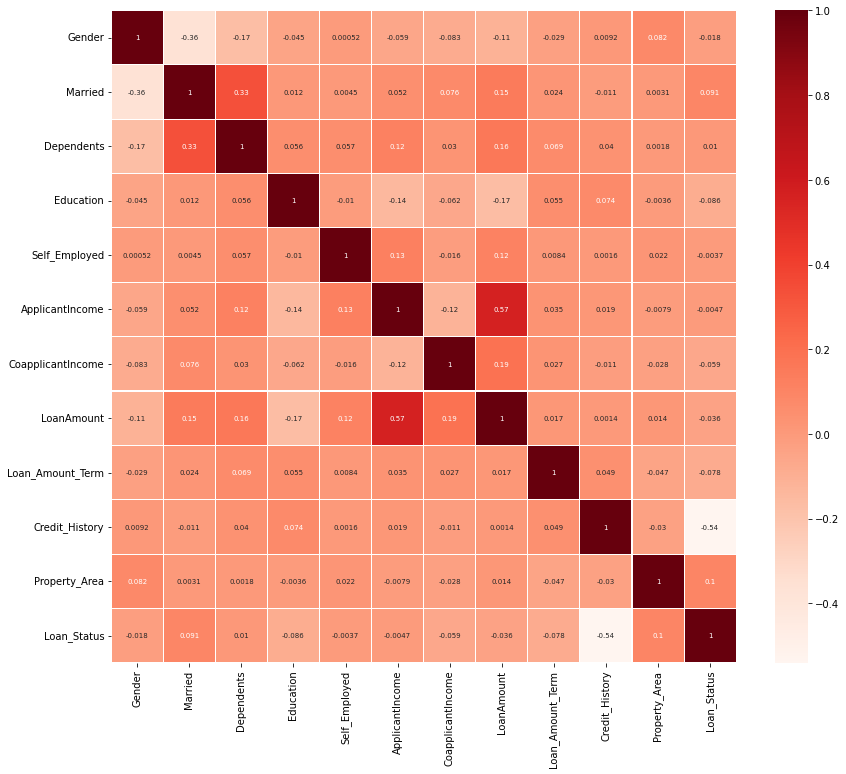

In [92]:
# Correlation analysis among the features using seaborn heatmaps
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), linewidths=.1, cmap="Reds", annot=True, annot_kws={"size": 7})
plt.yticks(rotation=0)
plt.show()

In [93]:
# STEP 4: Data Preparation

# Split the data into train and test sets for modeling (80% for training, and 20% for testing/evaluating the model).
train, test = train_test_split(df, test_size=0.2, random_state=1234, shuffle=True)

# Separate the Feature Columns and the Class/Label column as 'x' and 'y' respectively
x_train = train.loc[:, df.columns != 'Loan_Status']
x_test = test.loc[:, df.columns != 'Loan_Status']
y_train = train['Loan_Status']
y_test = test['Loan_Status']

In [94]:
# STEP 5: Training and Evaluation of the ML Model

# apply_ml_model function takes a list of Scikit-Learn initialized Machine Learning models as objects.
# Then, it trains the model with the training set, predicts classes for the test set and gives a classification report/F1-Score as an output.
# Since the dataset is imbalanced (68.2% Approved Loans, 32.2% Disapproved Loans), we cannot use accuracy as a main metric.
# So, we report the F1-scores and the complete classification report for each classifier model we apply on the dataset
# Since the positive class has more representation, we use class weights while training and see if that has any effect or not
def apply_ml_model(ml_model_list):
    for ml in ml_model_list:
        # Training the model
        ml.fit(x_train, y_train)
        # Predicting the class label for the Test data  
        pred = ml.predict(x_test)  
        # Evaluating the predicted class labels using accuracy score
        print("Accuracy Score: ", accuracy_score(y_test, pred), sep="\n")  
        # Generating a classification report for the predicted class labels
        print("Classification Report: ", classification_report(y_test, pred), sep="\n") 
        # Generating the confusion matrix to know the true-positives, true-negatives, false-positives and false-negatives
        cm = confusion_matrix(y_test, pred)
        print("Confusion Matrix: \n", cm)
        f, ax = plt.subplots(figsize=(5, 5))
        # Heatmap for the confusin matrix using seaborn
        sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
        plt.xlabel("y_pred")
        plt.ylabel("y_true")
        plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy Score: 
0.8455284552845529
Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.56      0.70        39
           1       0.83      0.98      0.90        84

    accuracy                           0.85       123
   macro avg       0.87      0.77      0.80       123
weighted avg       0.86      0.85      0.83       123

Confusion Matrix: 
 [[22 17]
 [ 2 82]]


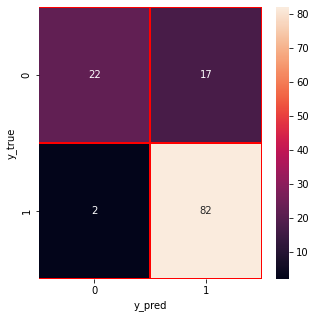

Accuracy Score: 
0.8455284552845529
Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.56      0.70        39
           1       0.83      0.98      0.90        84

    accuracy                           0.85       123
   macro avg       0.87      0.77      0.80       123
weighted avg       0.86      0.85      0.83       123

Confusion Matrix: 
 [[22 17]
 [ 2 82]]


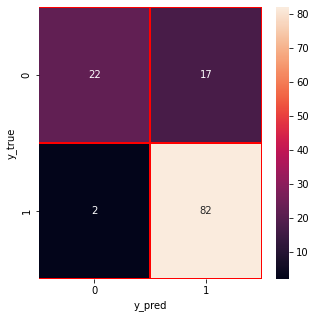

Accuracy Score: 
0.8292682926829268
Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        39
           1       0.85      0.92      0.88        84

    accuracy                           0.83       123
   macro avg       0.81      0.78      0.79       123
weighted avg       0.83      0.83      0.82       123

Confusion Matrix: 
 [[25 14]
 [ 7 77]]


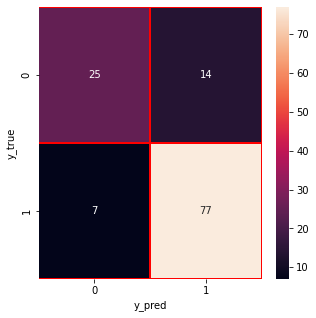

Accuracy Score: 
0.8292682926829268
Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        39
           1       0.85      0.92      0.88        84

    accuracy                           0.83       123
   macro avg       0.81      0.78      0.79       123
weighted avg       0.83      0.83      0.82       123

Confusion Matrix: 
 [[25 14]
 [ 7 77]]


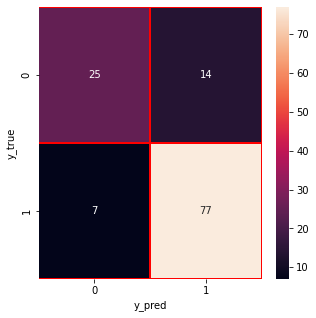

In [95]:
# STEP 6: Classification

# 6.1 : Using Logistic Regression Classifier for the dataset

# Giving 100 and 1000 for max_iter parameter to generate 2 different Logistic Regression models
apply_ml_model(
    [
        LogisticRegression(max_iter=100),
        LogisticRegression(max_iter=1000),
        LogisticRegression(max_iter=500, class_weight={1:1, 0:2}),
        LogisticRegression(max_iter=1000, class_weight={1:1, 0:2}),
    ]
)

Accuracy Score: 
0.8373983739837398
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.62      0.71        39
           1       0.84      0.94      0.89        84

    accuracy                           0.84       123
   macro avg       0.83      0.78      0.80       123
weighted avg       0.84      0.84      0.83       123

Confusion Matrix: 
 [[24 15]
 [ 5 79]]


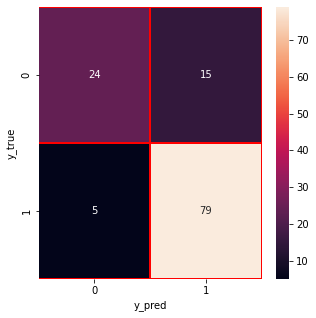

Accuracy Score: 
0.8373983739837398
Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.62      0.71        39
           1       0.84      0.94      0.89        84

    accuracy                           0.84       123
   macro avg       0.83      0.78      0.80       123
weighted avg       0.84      0.84      0.83       123

Confusion Matrix: 
 [[24 15]
 [ 5 79]]


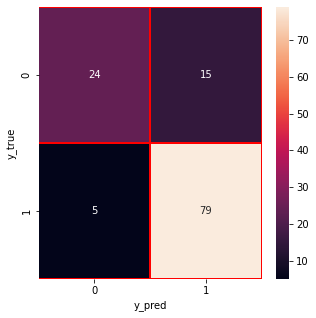

Accuracy Score: 
0.8211382113821138
Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.56      0.67        39
           1       0.82      0.94      0.88        84

    accuracy                           0.82       123
   macro avg       0.82      0.75      0.77       123
weighted avg       0.82      0.82      0.81       123

Confusion Matrix: 
 [[22 17]
 [ 5 79]]


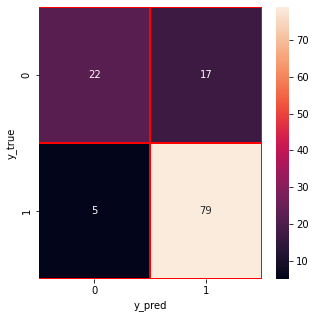

Accuracy Score: 
0.8292682926829268
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.56      0.68        39
           1       0.82      0.95      0.88        84

    accuracy                           0.83       123
   macro avg       0.84      0.76      0.78       123
weighted avg       0.83      0.83      0.82       123

Confusion Matrix: 
 [[22 17]
 [ 4 80]]


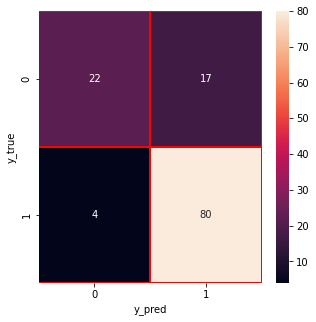

In [96]:
# 6.2: Using the Random Forest Classifier Classifier for the dataset

# Giving  200 and 1000 for n_estimators parameter to generate 4 different Random Forest Classifier model
apply_ml_model([
    RandomForestClassifier(n_estimators=200),
    RandomForestClassifier(n_estimators=500),
    RandomForestClassifier(n_estimators=500, class_weight={1:1, 0:2}),
    RandomForestClassifier(n_estimators=500, class_weight={1:1, 0:3}),
]
)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Accuracy Score: 
0.6747967479674797
Classification Report: 
              precision    recall  f1-score   support

           0       0.33      0.03      0.05        39
           1       0.68      0.98      0.80        84

    accuracy                           0.67       123
   macro avg       0.51      0.50      0.43       123
weighted avg       0.57      0.67      0.56       123

Confusion Matrix: 
 [[ 1 38]
 [ 2 82]]


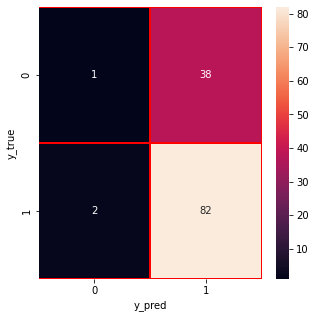

Accuracy Score: 
0.6178861788617886
Classification Report: 
              precision    recall  f1-score   support

           0       0.10      0.03      0.04        39
           1       0.66      0.89      0.76        84

    accuracy                           0.62       123
   macro avg       0.38      0.46      0.40       123
weighted avg       0.48      0.62      0.53       123

Confusion Matrix: 
 [[ 1 38]
 [ 9 75]]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


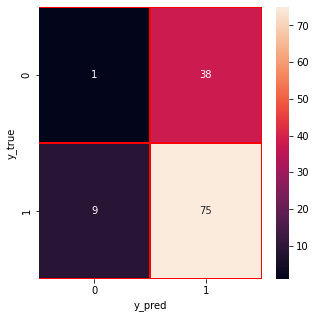

Accuracy Score: 
0.6178861788617886
Classification Report: 
              precision    recall  f1-score   support

           0       0.10      0.03      0.04        39
           1       0.66      0.89      0.76        84

    accuracy                           0.62       123
   macro avg       0.38      0.46      0.40       123
weighted avg       0.48      0.62      0.53       123

Confusion Matrix: 
 [[ 1 38]
 [ 9 75]]


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


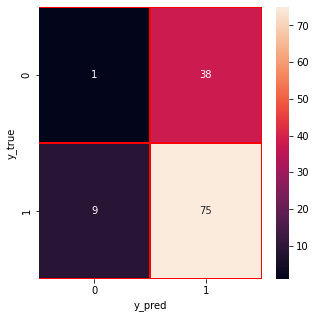

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Accuracy Score: 
0.6829268292682927
Classification Report: 
              precision    recall  f1-score   support

           0       0.50      0.03      0.05        39
           1       0.69      0.99      0.81        84

    accuracy                           0.68       123
   macro avg       0.59      0.51      0.43       123
weighted avg       0.63      0.68      0.57       123

Confusion Matrix: 
 [[ 1 38]
 [ 1 83]]


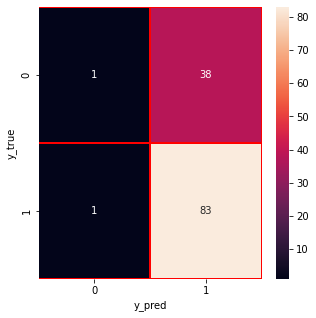

In [97]:
# 6.3: Using Support Vector Machine (SVM) Classifier for the dataset 

# Giving 100, 200, 500 for max_iter parameter
# to generate 4 different SVM models
apply_ml_model([
    SVC(kernel='linear', max_iter=100),
    SVC(kernel='linear', max_iter=500),
    SVC(kernel='linear', max_iter=500, class_weight={1:1, 0:2}),
    SVC(kernel='linear', max_iter=200, class_weight={1:1, 0:10}),
]
)